# (0) Download Butterfly 

In [ ]:
!kaggle datasets download -d gpiosenka/butterfly-images40-species

In [ ]:
import zipfile
with zipfile.ZipFile('butterfly-images40-species.zip', 'r') as zip_ref:
    zip_ref.extractall('data/butterfly')

# (1) Process Butterfly Data

In [2]:
from utils.data import create_butterfly_dataset
trainset, testset, normal_mapping, reverse_mapping = create_butterfly_dataset()
assert len(trainset) == 12594, 'Size of train set not match'
assert len(testset) == 500, 'Size of test set not match'

# (2) Import Classifier

In [3]:
from model.butterfly_classifier import DenseNet121

model = DenseNet121(num_classes=len(normal_mapping)).to('cuda')
model.load_state_dict(torch.load('./model/states/butterfly_classifier.pth'))

<All keys matched successfully>

# (3) Evaluate Untargeted Adversarial Examples

In [5]:
from torch.utils.data import DataLoader
from utils.base import eval_accuracy


acc = eval_accuracy(model, testset,  batch_size=100)
print('Accuracy on test set is {}'.format(acc))

tensor(0.9640, device='cuda:0')

In [26]:
from algo.attacker import adversarial_generator

test_img, test_label = testset[1]
test_img = test_img.unsqueeze(0)

adv_img = adversarial_generator(model = model, target_class=test_label,
                             image=test_img, 
                             search_var=1e-3,
                             sample_num=50,
                             bound=0.1,
                             lr=0.01,
                             query_limit=10000)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [08:06<00:00,  2.43s/it]


In [27]:
adv_logits = model(adv_img)
org_logits = model(test_img.to('cuda'))

print('Adversarial: predicted class is {}'.format(torch.argmax(adv_logits)))
print('Original: predicted class is {}'.format(torch.argmax(org_logits)))

print('Adversarial: logit of true class is {}'.format(adv_logits[0, test_label]))
print('Original: logit of true class is {}'.format(org_logits[0, test_label]))

print('Adversarial: probability of true class is {}'.format(F.softmax(adv_logits)[0, test_label]))
print('Original: probability of true class is {}'.format(F.softmax(org_logits)[0, test_label]))

tensor(63, device='cuda:0')
tensor(44, device='cuda:0')
tensor(1.3292, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.1222, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(12.5862, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.3680, device='cuda:0', grad_fn=<SelectBackward0>)


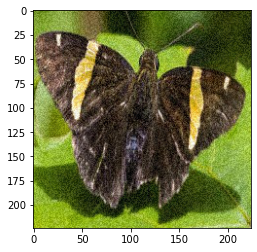

In [24]:
#plt.imshow(torch.transpose(testset[1][0],1,3))
def imshow(img):
    # unnormalize
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(testset[1][0])
imshow(fake.detach().cpu().view(testset[0][0].size()))

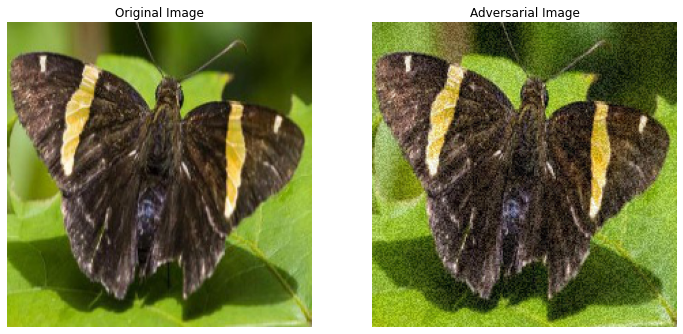

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
imshow(testset[1][0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(fake.detach().cpu().view(testset[0][0].size()))
plt.title('Adversarial Image')
plt.axis('off')

plt.show()